In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import os
import pickle5 as pickle

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

# import joypy
import pandas as pd

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
mt_preds = torch.load("finance_mt_preds_3.pt")

In [3]:
mt_x_list = mt_preds["x_paths"]

train_splits = list(range(252, 1259, int(252/2)))
eval_splits = list(range(252+int(252/2), 1259, int(252/2))) + [1259]
print(len(train_splits), len(eval_splits))

8 8


In [4]:
train_splits.insert(0,0)

In [5]:
ind_preds = torch.load("finance_ind_preds.pt", map_location="cpu")
ind_x_list = ind_preds["x_paths"]

In [6]:
times = np.arange(0, int(252/2), 20)
times[-1] -= 2

In [7]:
full_data = ind_preds["y"]

In [8]:
len(eval_splits)

8

In [9]:


mt_quantiles_list = []
ind_quantiles_list = []
for i in range(len(eval_splits)):
    
    torch.cuda.empty_cache()
    
    train_start = train_splits[i]
    train_end = train_splits[i+1]
    test_end = eval_splits[i]
    test_y = full_data[:, train_end:test_end]
    test_y = test_y[:, times].unsqueeze(-2).cpu()
    
    ind_quantiles_list.append((ind_x_list[i][..., times] > test_y).sum(1))
    mt_quantiles_list.append((mt_x_list[i][..., times] > test_y).sum(1))

In [10]:
ind_quantiles = torch.stack(ind_quantiles_list) / 100
mt_quantiles = torch.stack(mt_quantiles_list) / 100

In [11]:
ind_quantiles = ind_quantiles.reshape(-1, 7)
mt_quantiles = mt_quantiles.reshape(-1, 7)

In [12]:
times+1

array([  1,  21,  41,  61,  81, 101, 119])

/Users/wesleymaddox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


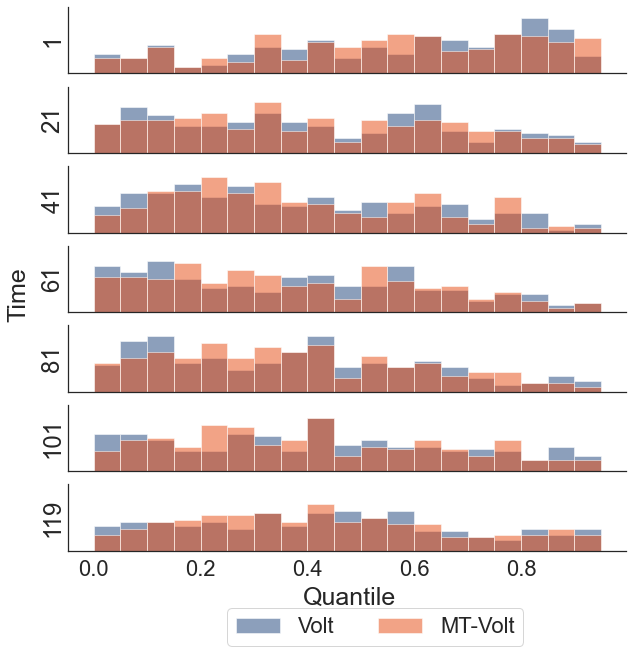

In [14]:
fig, ax = plt.subplots(7, 1, figsize = (10, 10), sharex=True, sharey=True)

for i in range(7):
    ax[i].hist(ind_quantiles[:, i].numpy(), alpha = 0.5, bins = np.arange(0, 1, 0.05), label="Volt")
    ax[i].hist(mt_quantiles[:, i].numpy(), color = palette[-2], bins = np.arange(0, 1, 0.05), 
               alpha = 0.5, label="MT-Volt")
    ax[i].set_ylim((0, 30))
    ax[i].set_yticks(ticks=[])
    ax[i].set_ylabel(str(times[i]+1))
ax[-1].legend(loc="lower center", bbox_to_anchor=(0.55, -1.6), ncol = 2)
plt.text(0.45, 0.05, "Quantile", fontsize=25, transform=plt.gcf().transFigure)
plt.text(0.04, 0.45, "Time", fontsize=25, transform=plt.gcf().transFigure, rotation=90)
sns.despine()
plt.tight_layout()
plt.savefig("lookahead_predictions_mt.pdf", bbox_inches = "tight")